In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cmath

from PIL import Image

In [2]:
def crop_center(arr, cropx, cropy):
    y, x = arr.shape[0], arr.shape[1]
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)

    if len(arr.shape) == 2:
       return arr[starty:starty+cropy, startx:startx+cropx]

    return arr[starty:starty+cropy, startx:startx+cropx, :]


In [3]:
img_name = 'filter_01.jpg'

img_filter = Image.open(img_name)

In [7]:
# Versão do filtro na escala de cinza

filter_gray = img_filter.convert("L")
filter_arr_gray = np.array(filter_gray, dtype=float)
filter_arr_gray = crop_center(filter_arr_gray, 512, 512).astype(np.complex64)

fft_filter_gray = fft2_stockham(filter_arr_gray)

In [8]:
# Versão do filtro com 3 canais de cor
filter_arr = np.array(img_filter, dtype=float)
filter_arr = crop_center(filter_arr, 512, 512)

filter_arr = np.transpose(filter_arr, (2, 1, 0))

_, H, W = filter_arr.shape

fft_filter = np.array([np.empty((H, W))] * 3, dtype=complex)

for channel in range(3):
    fft_filter_channel = fft2_stockham(filter_arr[channel])

    # fft_filter[channel] = np.fft.fftshift(fft_filter_channel)
    fft_filter[channel] = fft_filter_channel

/tmp/ipython-input-5-443497310.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  dst[group*m + j] = src[src_idx_l] + w * src[src_idx_r]
/tmp/ipython-input-5-443497310.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  dst[group*m + j + half_m] =  src[src_idx_l] - w * src[src_idx_r]


In [12]:
# Nome do arquivo de imagem
img_name = '2560x1440.jpg'

# Carregando a imagem com PIL
img = Image.open(img_name)

In [15]:
# Versão da imagem em escala de cinza
img_gray = img.convert("L")
img_arr_gray = np.array(img_gray, dtype=float)
imgs_arr_gray = [crop_center(img_arr_gray, size, size).astype(np.complex64) for size in [128, 256, 512, 1024]]

In [14]:
# Convertendo a imagem para um array NumPy

img_arr = np.array(img, dtype=float)
imgs_arr = [crop_center(img_arr, size, size).astype(np.complex64) for size in [128, 256, 512, 1024]]

In [16]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 10.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.1-cp311-cp311-linux_x86_64.whl size=660712 sha256=910ce8be00d546ab024fb66c1f7ae485471c0c80f3dc9303d440526e6c1ce0ec
  Stored in directory: /root/.cache/pip/wheels/49/0a/64/6530a5fde64f984ebb4992e38744fdfd2a61f510377b3a24d9
Successfully built pycuda


In [9]:
import pycuda.driver as cuda
import pycuda.autoinit  # Inicializa automaticamente o driver CUDA

# Obtém o dispositivo atual (GPU)
device = cuda.Device(0)

# Informações gerais
print("Nome da GPU:", device.name())
print("Máximo de threads por bloco:", device.get_attribute(cuda.device_attribute.MAX_THREADS_PER_BLOCK))
print("Dimensões máximas dos blocos (x, y, z):", device.get_attribute(cuda.device_attribute.MAX_BLOCK_DIM_X),
      device.get_attribute(cuda.device_attribute.MAX_BLOCK_DIM_Y),
      device.get_attribute(cuda.device_attribute.MAX_BLOCK_DIM_Z))
print("Dimensões máximas da grade (grid) (x, y, z):", device.get_attribute(cuda.device_attribute.MAX_GRID_DIM_X),
      device.get_attribute(cuda.device_attribute.MAX_GRID_DIM_Y),
      device.get_attribute(cuda.device_attribute.MAX_GRID_DIM_Z))

Nome da GPU: Tesla T4
Máximo de threads por bloco: 1024
Dimensões máximas dos blocos (x, y, z): 1024 1024 64
Dimensões máximas da grade (grid) (x, y, z): 2147483647 65535 65535


# CPU Image Processing

In [10]:
def stockham_fft(signal):
    N = len(signal)

    stages = int(np.log2(N))

    src = signal.copy()
    dst = np.zeros(N, dtype=complex)

    for stage in range(stages):
        m = 2 ** (stage + 1)

        half_m = m // 2

        for idx in range(N // 2):
            src_idx_l = idx
            src_idx_r = idx + N // 2

            group = idx // half_m

            j = idx % half_m

            w = cmath.exp(-2j * cmath.pi * j / m)

            dst[group*m + j] = src[src_idx_l] + w * src[src_idx_r]
            dst[group*m + j + half_m] =  src[src_idx_l] - w * src[src_idx_r]

        src, dst = dst, src

    return src


def stockham_ifft(signal):
    N = len(signal)
    stages = int(np.log2(N))

    src = signal.copy()
    dst = np.zeros(N, dtype=complex)

    for stage in range(stages):
        m = 2 ** (stage + 1)
        half_m = m // 2

        for idx in range(N // 2):
            src_idx_l = idx
            src_idx_r = idx + N // 2

            group = idx // half_m
            j = idx % half_m

            w = cmath.exp(+2j * cmath.pi * j / m)

            dst[group*m + j] = src[src_idx_l] + w * src[src_idx_r]
            dst[group*m + j + half_m] = src[src_idx_l] - w * src[src_idx_r]

        src, dst = dst, src

    return src / N


def fft2_stockham(matrix):
    temp = np.array([stockham_fft(row) for row in matrix])
    result = np.array([stockham_fft(col) for col in temp.T]).T
    return result


def ifft2_stockham(matrix):
    temp = np.array([stockham_ifft(row) for row in matrix])
    result = np.array([stockham_ifft(col) for col in temp.T]).T
    return result

In [11]:
def normalize_array(array: np.array):
    magnitude_norm = 255 * (array / np.max(array))

    return magnitude_norm.astype(np.uint8)


def process_image_cpu(array: np.array):
    fft_img = np.empty_like(array, dtype=complex)

    if len(array.shape) == 3: # Imagem com 3 canais de cor
        for  channel in range(3):
            fft_array = fft2_stockham(array[channel])

            # fft_array = np.fft.fftshift(fft_array)

            fft_img[channel] = fft_array + fft_filter[channel]

            f = ifft2_stockham(fft_img[channel])

            fft_img[channel] = np.fft.ifft2(f).real


    if len(array.shape) == 2: # Imagem na escala de cinza
        fft_array = fft2_stockham(array)

        F = fft_array + fft_filter_gray

        fft_img = ifft2_stockham(F)


    return normalize_array(fft_img)

# GPU Image Processing

In [16]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
from pycuda.compiler import SourceModule

# N = imgs_arr[3].shape[0]
# signal = imgs_arr[3]

mod = SourceModule("""
// Multiplicação complexa
__device__ float2 complex_mul(float2 a, float2 b) {
    return make_float2(
        a.x * b.x - a.y * b.y,
        a.x * b.y + a.y * b.x
    );
}


__device__ float2 twiddle_pos(int j, int m) {
    float theta = +2.0f * 3.14159265359f * j / m;
    return make_float2(cosf(theta), sinf(theta));
}

__device__ float2 twiddle_neg(int j, int m) {
    float theta = -2.0f * 3.14159265359f * j / m;
    return make_float2(cosf(theta), sinf(theta));
}

// Kernel serial: apenas 1 thread executando tudo
__device__ void fft_stockham_serial(float2 *src, float2 *dst, int N) {
    __syncthreads();

    int stages = 0;

    int n = N;

    while (n > 1) {
        n /= 2;
        stages++;
    }

    for (int stage = 0; stage < stages; stage++) {
        int m = 1 << (stage + 1);
        int half_m = m / 2;

        for (int idx = 0; idx < N / 2; idx++) {
            int group = idx / half_m;
            int j = idx % half_m;

            int src_idx_l = idx;
            int src_idx_r = idx + N / 2;

            float2 w = twiddle_neg(j, m);
            float2 a = src[src_idx_l];
            float2 b = complex_mul(w, src[src_idx_r]);

            dst[group * m + j] = make_float2(a.x + b.x, a.y + b.y);
            dst[group * m + j + half_m] = make_float2(a.x - b.x, a.y - b.y);
        }

        for (int i = 0; i < N; i++) {
            src[i] = dst[i];
        }
    }
}

__device__ void ifft_stockham_serial(float2 *src, float2 *dst, int N) {
    __syncthreads();

    int stages = 0;

    int n = N;

    while (n > 1) {
        n /= 2;
        stages++;
    }

    for (int stage = 0; stage < stages; stage++) {
        int m = 1 << (stage + 1);
        int half_m = m / 2;

        for (int idx = 0; idx < N / 2; idx++) {
            int group = idx / half_m;
            int j = idx % half_m;

            int src_idx_l = idx;
            int src_idx_r = idx + N / 2;

            float2 w = twiddle_pos(j, m);
            float2 a = src[src_idx_l];
            float2 b = complex_mul(w, src[src_idx_r]);

            dst[group * m + j] = make_float2(a.x + b.x, a.y + b.y);
            dst[group * m + j + half_m] = make_float2(a.x - b.x, a.y - b.y);
        }

        for (int i = 0; i < N; i++) {
            src[i] = dst[i];
        }
    }

    for (int i = 0; i < N; i++) {
        src[i].x /= N;
        src[i].y /= N;
    }
}

__device__ void transpose(float2 *input, int size, int tid) {
    if (tid >= size) return;
    for (int i = tid + 1; i < size; i++) {
        float2 temp = input[tid * size + i];
        input[tid * size + i] = input[i * size + tid];
        input[i * size + tid] = temp;
    }
}

__global__ void fft2_stockham(float2 *src, float2 *dst, int N) {
    int tid = threadIdx.x + blockDim.x * blockIdx.x;

    fft_stockham_serial(&src[tid * N], &dst[tid * N], N);

    __syncthreads();

    transpose(src, N, tid);

    __syncthreads();

    fft_stockham_serial(&src[tid * N], &dst[tid * N], N);

    __syncthreads();

    transpose(src, N, tid);
}

__global__ void ifft2_stockham(float2 *src, float2 *dst, int N) {
    int tid = threadIdx.x + blockDim.x * blockIdx.x;

    transpose(src, N, tid);

    __syncthreads();

    ifft_stockham_serial(&src[tid * N], &dst[tid * N], N);

    __syncthreads();

    transpose(src, N, tid);

    __syncthreads();

    ifft_stockham_serial(&src[tid * N], &dst[tid * N], N);
}
""")

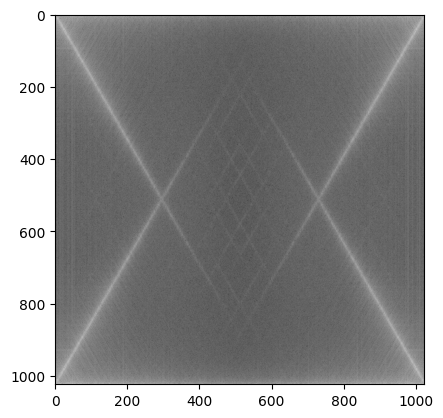

In [ ]:
plt.imshow(20*np.log(np.abs(result)+1), cmap="gray")

In [29]:
def fft_gpu (array):
    signal = array
    N = array.shape[0]

    src_gpu = cuda.mem_alloc(signal.nbytes)
    dst_gpu = cuda.mem_alloc(signal.nbytes)

    signal = np.ascontiguousarray(signal)

    cuda.memcpy_htod(src_gpu, signal)

    stockham_serial = mod.get_function("fft2_stockham")
    stockham_serial(src_gpu, dst_gpu, np.int32(N), block=(N, 1, 1), grid=(1, 1))

    fft_array = np.empty_like(signal)

    cuda.memcpy_dtoh(fft_array, src_gpu)

    return fft_array

def ifft_gpu (array):
    signal = array
    N = array.shape[0]

    src_gpu = cuda.mem_alloc(signal.nbytes)
    dst_gpu = cuda.mem_alloc(signal.nbytes)

    signal = np.ascontiguousarray(signal)

    cuda.memcpy_htod(src_gpu, signal)

    inv_stockham = mod.get_function("ifft2_stockham")
    inv_stockham(src_gpu, dst_gpu, np.int32(N), block=(N, 1, 1), grid=(1, 1))

    ifft_array = np.empty_like(signal)

    cuda.memcpy_dtoh(ifft_array, src_gpu)

    return ifft_array


In [18]:
def process_image_gpu(array: np.array):
    fft_img = np.empty_like(array, dtype=complex)

    if len(array.shape) == 3:
        for channel in range(3):
            fft_array = fft_gpu(array[channel])

            fft_img[channel] = fft_array + fft_filter[channel]

            # f = np.fft.ifftshift(fft_img[channel])

            fft_img[channel] = ifft_gpu(fft_img[channel]).real

    if len(array.shape) == 2: # Imagem na escala de cinza
        fft_array = fft_gpu(array)

        F = fft_array + fft_filter_gray

        fft_img = ifft_gpu(F)

    return normalize_array(fft_img)

# Webcam

In [50]:
import cv2 as cv

# camera = cv.VideoCapture(0)

# camera.set(cv.CAP_PROP_FRAME_WIDTH, 1280)
# camera.set(cv.CAP_PROP_FRAME_HEIGHT, 720)

# if not camera.isOpened():
#     print("Error opening camera.")
#     exit()


while True:
    # status, frame = camera.read()
    frame = img

    array = np.array(frame, dtype=float)

    try:
        array = crop_center(array, 512, 512).astype(np.complex64)
        if len(array.shape) == 3:
            array = np.transpose(array, (2, 1, 0))

        # array = process_image_cpu(array)
        array = process_image_gpu(array)

        if len(array.shape) == 3:
            array = np.transpose(array, (2, 1, 0))

        break
    except Exception as e:
        print(e)
        continue

    # if not status or cv.waitKey(1) & 0xff == ord('q'):
    #     break

    # cv.imshow("Camera", array)

# camera.release()

# cv.destroyAllWindows()

/tmp/ipython-input-11-3195436614.py:2: RuntimeWarning: invalid value encountered in divide
  magnitude_norm = 255 * (array / np.max(array))
/tmp/ipython-input-11-3195436614.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  return magnitude_norm.astype(np.uint8)
/tmp/ipython-input-11-3195436614.py:4: RuntimeWarning: invalid value encountered in cast
  return magnitude_norm.astype(np.uint8)


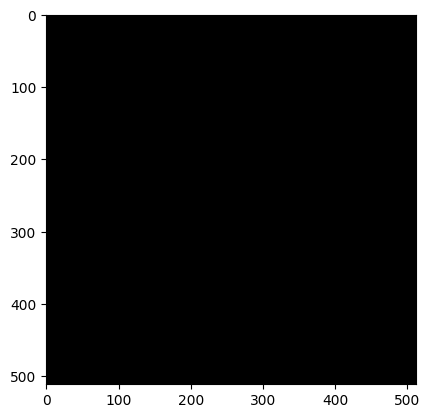

In [51]:
plt.imshow(array)